In [1]:
import os
from pysmiles import read_smiles
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch_geometric
import torch
from torch import nn
from torch_geometric.data import Dataset, DataLoader
from torchvision import models
import deepchem as dc

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.7.1+cu110
Cuda available: True
Torch geometric version: 1.7.2


# Dataset

In [2]:
class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        #self.data = self.data.iloc[29628:]
        #print(self.data.iloc[-1])
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            f = featurizer.featurize(mol["SMILES"])
            data = f[0].to_pyg_graph()
            data.smiles = mol["SMILES"]
            if not self.test:
                data.y = self._get_label(mol["target"])
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
            

    def _get_label(self, label):
        if not self.test:
            label = np.asarray([label])
            return torch.tensor(label, dtype=torch.float32)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

# Hyperparameters

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 200
num_layers = 1
dropout_rate = 0.1
embedding_size = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = "./models/best_model.pt"

In [14]:
train_dataset = MoleculeDataset(root="../data/", filename="new_train.csv")
train_dataset  = train_dataset.shuffle()

In [15]:
train_dataset

MoleculeDataset(30344)

In [16]:
int(len(train_dataset)*0.8)

24275

In [17]:
train_dataloader = DataLoader(train_dataset[:24275], batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
val_dataloader = DataLoader(train_dataset[24275:], batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [18]:
sample_batch = next(iter(train_dataloader))
sample_batch

Batch(batch=[1592], edge_attr=[3412, 11], edge_index=[2, 3412], ptr=[65], smiles=[64], x=[1592, 30], y=[64])

In [19]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
num_features = train_dataset.num_features

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = torch.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = torch.tanh(hidden)
        #hidden = F.dropout(hidden, p=0.5, training=self.training)
        hidden = self.conv2(hidden, edge_index)
        hidden = torch.tanh(hidden)
        #hidden = F.dropout(hidden, p=0.5, training=self.training)
        hidden = self.conv3(hidden, edge_index)
        hidden = torch.tanh(hidden)
        #hidden = F.dropout(hidden, p=0.5, training=self.training)
        
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

In [20]:
model = GCN()
model = model.to(device)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model

Number of parameters:  53761


GCN(
  (initial_conv): GCNConv(30, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [22]:
def train_step(batch_item, epoch, batch, training):
    x = batch_item['x'].float()
    edge_index = batch_item['edge_index']
    batch = batch_item['batch']
    label = batch_item['y']

    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output, h = model(x, edge_index, batch)
            #print(output.shape)
            #print(label.shape)
            loss = criterion(output.view(-1), label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output, h = model(x, edge_index, batch)
            #print(output.shape)
            #print(label.shape)            
            loss = criterion(output.view(-1), label)
            
        return loss

In [23]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_item.to(device)
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_item.to(device)
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model.state_dict(), save_path)

380it [00:08, 43.20it/s, Epoch=1, Loss=0.309303, Total Loss=0.292115]
95it [00:02, 46.56it/s, Epoch=1, Val Loss=0.245225, Total Val Loss=0.264908]
380it [00:08, 43.18it/s, Epoch=2, Loss=0.240097, Total Loss=0.260145]
95it [00:01, 49.31it/s, Epoch=2, Val Loss=0.277595, Total Val Loss=0.255820]
380it [00:08, 42.67it/s, Epoch=3, Loss=0.258524, Total Loss=0.254361]
95it [00:02, 47.16it/s, Epoch=3, Val Loss=0.226521, Total Val Loss=0.250840]
380it [00:08, 43.63it/s, Epoch=4, Loss=0.359437, Total Loss=0.250163]
95it [00:02, 45.82it/s, Epoch=4, Val Loss=0.251308, Total Val Loss=0.247929]
380it [00:08, 42.81it/s, Epoch=5, Loss=0.225301, Total Loss=0.246315]
95it [00:02, 47.03it/s, Epoch=5, Val Loss=0.217967, Total Val Loss=0.243746]
380it [00:08, 45.60it/s, Epoch=6, Loss=0.261388, Total Loss=0.243561]
95it [00:02, 46.33it/s, Epoch=6, Val Loss=0.253291, Total Val Loss=0.241253]
380it [00:08, 45.70it/s, Epoch=7, Loss=0.186062, Total Loss=0.240277]
95it [00:01, 55.78it/s, Epoch=7, Val Loss=0.2076

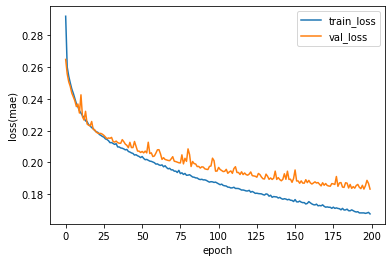

In [24]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

In [25]:
loaded_model = GCN()
loaded_model.load_state_dict(torch.load(save_path))

#model.eval()

<All keys matched successfully>

In [26]:
for param in loaded_model.parameters():
    print(param)
    break

Parameter containing:
tensor([[ 0.1799,  0.1215, -0.0757,  ..., -0.0434, -0.0972, -0.1635],
        [ 0.1750, -0.0348,  0.2011,  ..., -0.1269,  0.0118, -0.2038],
        [ 0.0776, -0.2186,  0.1511,  ..., -0.2740,  0.0862,  0.2218],
        ...,
        [-0.1008, -0.0654,  0.0891,  ..., -0.2494,  0.3802,  0.3667],
        [-0.1447, -0.0086, -0.1410,  ..., -0.0903,  0.0287,  0.1302],
        [-0.0816,  0.0359,  0.1552,  ...,  0.0931,  0.0511, -0.0073]],
       requires_grad=True)


In [27]:
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [28]:
test

,uid,SMILES
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...
...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...
598,test_598,CC1(C)c2ccccc2N(c2ccc(-c3cc(-c4ccc(N5c6ccccc6C...
599,test_599,Cc1nc(-c2ccc(N3c4ccccc4C(C)(C)c4ccccc43)cc2)cc...
600,test_600,c1ccc2c(c1)Oc1ccccc1N2c1ccc(-c2nc3ccccc3s2)cc1


In [29]:
test_dataset = MoleculeDataset(root="../data/", filename="test.csv", test=True)

In [30]:
test_dataset[0]

Data(edge_attr=[56, 11], edge_index=[2, 56], smiles="COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C", x=[26, 30])

In [31]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test_dataloader

In [32]:
test_batch = next(iter(test_dataloader))
test_batch

Batch(batch=[1668], edge_attr=[3574, 11], edge_index=[2, 3574], ptr=[65], smiles=[64], x=[1668, 30])

In [33]:
for batch_item in test_dataloader:
    print(batch_item)
    break

Batch(batch=[1668], edge_attr=[3574, 11], edge_index=[2, 3574], ptr=[65], smiles=[64], x=[1668, 30])


In [34]:
def predict(dataset):
    #loaded_model.to(device)
    loaded_model.eval()
    result = []
    for batch_item in dataset:
        batch_item.to(device)
        x = batch_item['x'].float()
        edge_index = batch_item['edge_index']
        batch = batch_item['batch']
        with torch.no_grad():
            output, h = loaded_model(x, edge_index, batch)
        output = output[:, 0]
        output = output.cpu().numpy()
        result.extend(output)
        
    return result

In [35]:
pred = predict(test_dataloader)

RuntimeError: Tensor for argument #3 'mat2' is on CPU, but expected it to be on GPU (while checking arguments for addmm)

In [ ]:
submission['ST1_GAP(eV)'] = pred

In [ ]:
submission.info()

In [ ]:
submission

In [ ]:
submission.to_csv('dacon_baseline.csv', index=False)

In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    'dacon_baseline.csv', 
    '59375e1f3b2f6e39215d683eaee1a165fb30ef348d1da88be153f64c17dfe759', 
    '235789', 
    'melona', 
    'gnn_2'
)